5.2.2. 순전파 코드 구현

[-6.28318531 -6.02672876 -5.77027222 -5.51381568 -5.25735913 -5.00090259
 -4.74444605 -4.48798951 -4.23153296 -3.97507642 -3.71861988 -3.46216333
 -3.20570679 -2.94925025 -2.6927937  -2.43633716 -2.17988062 -1.92342407
 -1.66696753 -1.41051099 -1.15405444 -0.8975979  -0.64114136 -0.38468481
 -0.12822827  0.12822827  0.38468481  0.64114136  0.8975979   1.15405444
  1.41051099  1.66696753  1.92342407  2.17988062  2.43633716  2.6927937
  2.94925025  3.20570679  3.46216333  3.71861988  3.97507642  4.23153296
  4.48798951  4.74444605  5.00090259  5.25735913  5.51381568  5.77027222
  6.02672876  6.28318531]


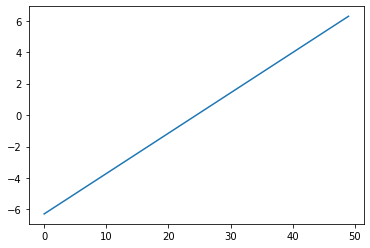

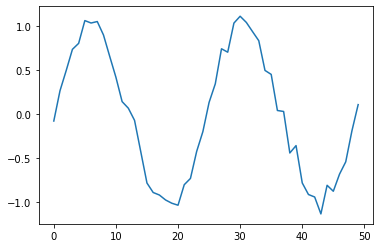

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# -- 각 설정값 --
n_time = 10      # 시점 수
n_in = 1         # 입력층 뉴런 수
n_mid = 20       # 은닉층 뉴런 수
n_out = 1        # 출력층 뉴런 수

eta = 0.01       # 학습률
epochs = 101
batch_size = 8
interval = 10    # 경과 표시 간격

def sigmoid(x):
    return 1/(1+np.exp(-x))

# -- 훈련 데이터 생성 --
sin_x = np.linspace(-2*np.pi, 2*np.pi)
# print(sin_x)
# plt.plot(range(len(sin_x)), sin_x)
# plt.show()

sin_y = np.sin(sin_x) + 0.1*np.random.randn(len(sin_x))
# plt.plot(range(len(sin_y)), sin_y)
# plt.show()

n_sample = len(sin_x) - n_time    # 샘플 수
input_data = np.zeros()
